In [3]:
# load the black code formatter for jupyter lab
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend. Then plot the measurements in time to give an idea of the trend.

Import needed libraries

In [4]:
from IPython.display import display
# One ring to handle numbers
import numpy as np
import pandas as pd
import scipy.stats as stats

# One ring to handle time
import datetime as dt
from datetime import date
import time

# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [5]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = "data/bp_log.csv"
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian
bp_stages = {
    "normal": "#aecd55",
    "elevated": "#fcec4f",
    "stage1": "#f4b93f",
    "stage2": "#ad451d",
    "crisis": "#8c1e1b",
}
BP_LOG_FIELDNAMES = [
    "Date",
    "Time",
    "Systolic (mmHg)",
    "Diastolic (mmHg)",
    "Pulse (bpm)",
    "Irregular heartbeat detected",
    "Body Movement",
    "Cuff wrap guide",
    "Positioning Indicator",
    "Measurement Mode",
    "Possible Afib",
    "Device",
    "Notes",
]

### Define some functions:

In [6]:
def classify_bp(row):
    """
    Categorize the BP level as per guidelines
    """
    if row.SYS < 120 and row.DIA < 80:
        return "normal"
    elif (row.SYS >= 120 and row.SYS <= 129) and row.DIA < 80:
        return "elevated"
    elif (row.SYS >= 130 and row.SYS <= 139) or (row.DIA >= 80 and row.DIA <= 89):
        return "stage1"
    elif (row.SYS >= 140 and row.SYS <= 179) or (row.DIA >= 90 and row.DIA <= 119):
        return "stage2"
    elif row.SYS > 180 or row.DIA > 120:
        return "crisis"

In [7]:
def partofday(hour):
    """
    generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above
    """
    if hour <= AM_LIMIT:
        return "AM"
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return "MID"
    else:
        return "PM"

In [8]:
def regplot_of_df(df, barwidth):
    """
    Regression plot of SYStolic and DIAstolic values passed to it
    Each pair of reading connected by a vertical line superposing a barplot
    The vertical bar lines are colored accordingly to the bp_stages dictionary
    and to the classification of that reading's stage as per the classify_bp function
    Second parameter needs adjustement according to the number of X values
    """
    plt.figure(figsize=(44, 16))
    # as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch in the "elapsed_seconds" column
    ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS", scatter_kws={"s": 100})
    ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA", scatter_kws={"s": 100})
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # set some other visuals
    ax.set_xlabel("Measurement Date", fontsize=28, labelpad=20)
    ax.set_ylabel("Arm cuff BP (mmHg)", fontsize=28)
    plt.legend(prop={"size": 20})
    # now add a vertical bar joining the SYS and DIA readings
    plt.bar(
        x=df["unix"],
        height=df["SYS"] - df["DIA"],
        bottom=df["DIA"],
        width=barwidth,
        color=df["bp_color"],
    )
    # create some whitespace horizontally around the plot values
    ax.set_xlim(df["unix"].min() - 10000, df["unix"].max() + 10000)
    # now convert the epoch values back to a YYYY-MM-DD string for the x labels
    # localtime converts the epoch into a datetime object, and strftime converts it into a string
    new_labels = [
        time.strftime("%Y-%m-%d", time.localtime(item)) for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels)
    plt.show()

### NOW read the CSV data and rename and add a few fields

In [12]:
df = pd.read_csv(LOGNAME)

##### check if CSV format is the expected one otherwise abort with message

In [13]:
if not (BP_LOG_FIELDNAMES == list(df.columns.values)):
    print(
        f"CSV field names are not what we expect. Check {LOGNAME} file headers please."
    )
    quit()

In [31]:
# recreate a Measurement date and time text field used for some labels
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(
    columns={
        "Systolic (mmHg)": "SYS",
        "Diastolic (mmHg)": "DIA",
        "Pulse (bpm)": "Pulse",
    },
    inplace=True,
)

#### Add a measurement datetime column and a couple of derived measures


In [15]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"]
)  # generate a datetime object from the two Date and Time strings
df["unix"] = (
    df["datetime"].astype("int64") / 1e9
)  # generate seconds from Unix epoch from the datetime object
df["elapsed_seconds"] = (
    df["datetime"] - df["datetime"].min()
).dt.total_seconds()  # generate seconds from earliest observation time

#### Add a new "partofday" categorical new column in the dataframe

In [16]:
### using apply and partofday function superseded by the mask method below
# df["partofday"] = df.apply(
#    lambda row: partofday(pd.to_datetime(row["Measurement Date"]).hour), axis=1
# )
maskAM = df[df["datetime"].dt.hour < 11].index
maskPM = df[df["datetime"].dt.hour > 17].index
df.insert(1, "partofday", "MID")
df.loc[maskAM, "partofday"] = "AM"
df.loc[maskPM, "partofday"] = "PM"

#### Also add a BP stage category (normal, elevated, stage1, stage2, crisis) and show relative frequency

In [17]:
df["bp_stage"] = df.apply(classify_bp, axis=1)

#### Add a bp_color column with the Hex color value corresponding to the BP stage as per the bp_stages dictionary

In [18]:
df["bp_color"] = df[
    "bp_stage"
]  # add a BP stage classification (bp_stage) column to the dataframe
df["bp_color"] = df["bp_color"].map(bp_stages)

#### Now just drop currently unneeded columns, just for being tidy :)

In [19]:
df.drop(
    [
        "Irregular heartbeat detected",
        "Body Movement",
        "Cuff wrap guide",
        "Positioning Indicator",
        "Measurement Mode",
        "Possible Afib",
        "Device",
        "Notes",
    ],
    inplace=True,
    axis=1,
)

#### So here's the dataframe we'll work with

In [32]:
df.sample(5)

,Date,partofday,Time,SYS,DIA,Pulse,Measurement Date,datetime,unix,elapsed_seconds,bp_stage,bp_color
87,20 May 2021,AM,10:13,119,69,71,20 May 2021 10:13,2021-05-20 10:13:00,1.621506e+09,1120140.0,normal,#aecd55
47,22 Jul 2021,MID,13:00,113,75,74,22 Jul 2021 13:00,2021-07-22 13:00:00,1.626959e+09,6573360.0,normal,#aecd55
38,27 Jul 2021,PM,21:37,113,75,70,27 Jul 2021 21:37,2021-07-27 21:37:00,1.627422e+09,7036380.0,normal,#aecd55
11,29 Jun 2022,AM,08:16,105,73,67,29 Jun 2022 08:16,2022-06-29 08:16:00,1.656491e+09,36105120.0,normal,#aecd55
68,10 Jul 2021,PM,21:19,110,73,71,10 Jul 2021 21:19,2021-07-10 21:19:00,1.625952e+09,5566500.0,normal,#aecd55


#### Compute some correlation coefficients between SYS and DIA reading

#### Let's perform the Shapiro-Wilk test for normality

In [33]:
stats.shapiro(df["SYS"])

ShapiroResult(statistic=0.9395816922187805, pvalue=0.00029176793759688735)

In [34]:
stats.shapiro(df["DIA"])

ShapiroResult(statistic=0.9655649662017822, pvalue=0.014039509929716587)

#### Now compute some correlation coefficients

In [35]:
df["SYS"].corr(df["DIA"])  # Pearson's r

0.8695613582906626

In [36]:
df["SYS"].corr(df["DIA"], method="kendall")  # Kendall's tau

0.6808305879252764

### Count each reading's category according to guidelines

In [37]:
# count how many ocurrences of each BP reading per BP class
bp_cat_freq = df["bp_stage"].value_counts()

In [38]:
bp_cat_freq

normal      44
stage1      35
elevated    15
Name: bp_stage, dtype: int64

<AxesSubplot:>

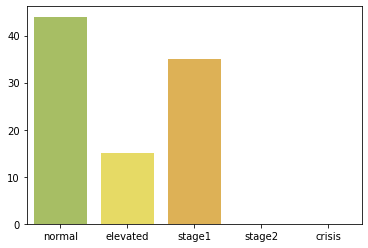

In [30]:
# reindex the data
plot_data = bp_cat_freq.reindex(bp_stages.keys())
sns.barplot(x=plot_data.index, y=plot_data.values, palette=bp_stages.values())

### Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [18]:
sns.set_theme(style="whitegrid")

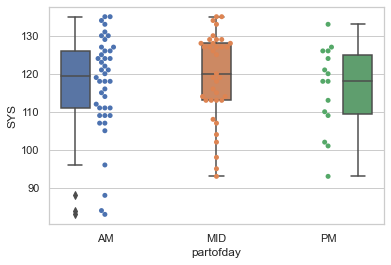

In [19]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

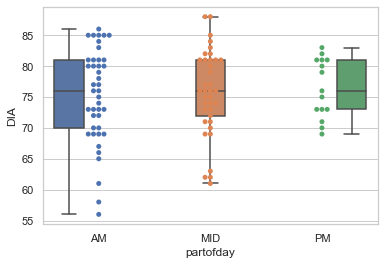

In [20]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

### Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [21]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "PM"])

Ttest_indResult(statistic=0.3318677450420735, pvalue=0.7412505038434571)

In [22]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "PM"])

Ttest_indResult(statistic=-0.596150772600291, pvalue=0.5535202269865496)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [23]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.7623620118709011, pvalue=0.44817303763172134)

In [24]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.31388918667386473, pvalue=0.7544540107958753)

#### Conclusion: no significant distribution variability of blood presure values between the three daily phases 

### Let's now plot the BP values and see what's their temporal trend in time

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_27013/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


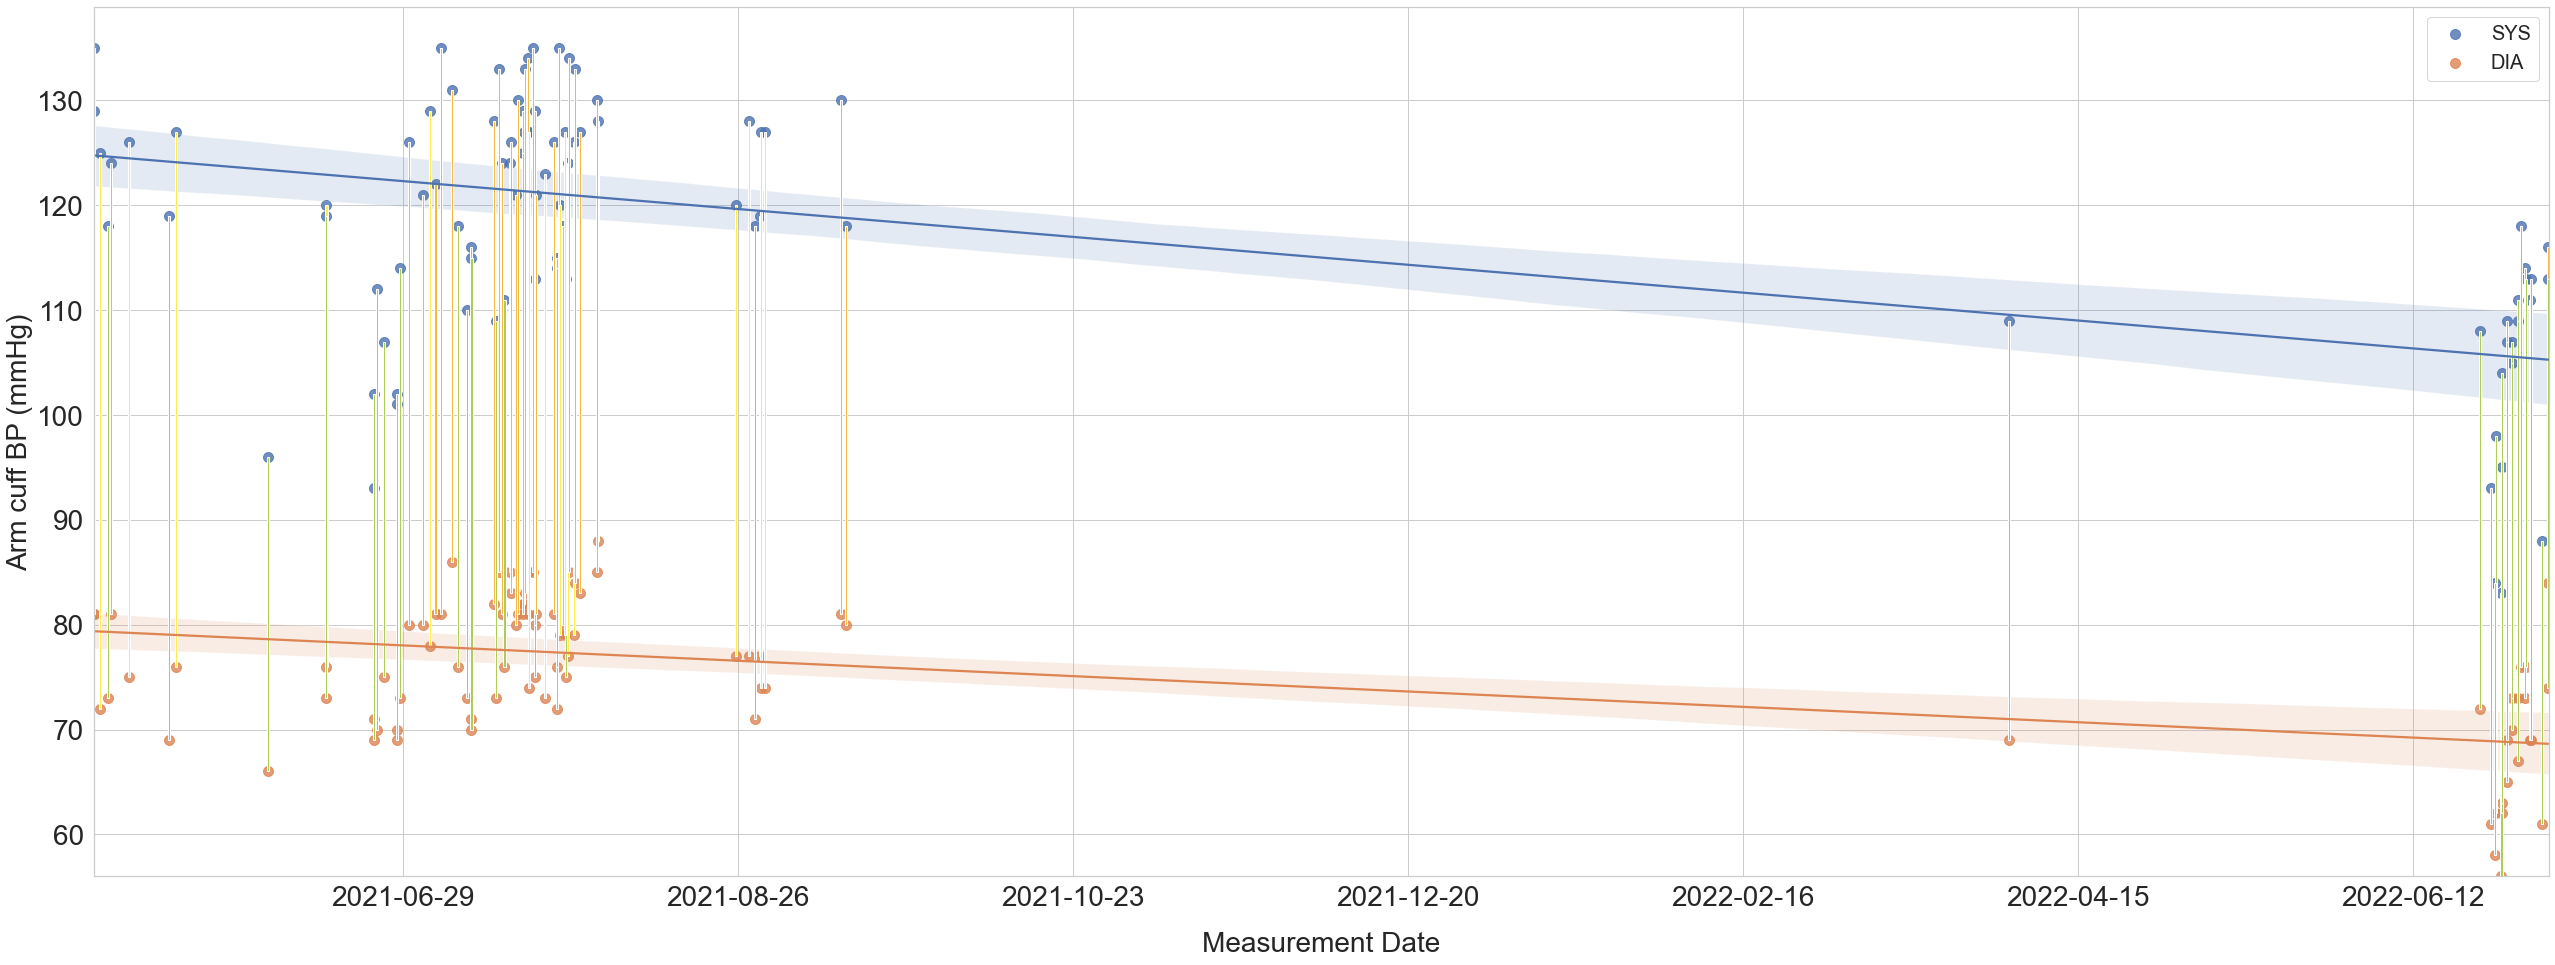

In [25]:
regplot_of_df(df, 30000)

### Extract the data subset for last week and last 30 days measurments

In [39]:
today = date.today()
week_prior = today - dt.timedelta(weeks=1)
month_prior = today - dt.timedelta(days=30)
df_lastweek = df[df["datetime"].dt.date >= week_prior]
df_lastmonth = df[df["datetime"].dt.date >= month_prior]

# Now describe last week measurements if available

In [40]:
df_lastweek.describe()

,SYS,DIA,Pulse,unix,elapsed_seconds
count,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01
mean,110.600000,72.200000,64.400000,1.656764e+09,3.637837e+07
std,8.342661,6.196773,4.695151,1.698209e+05,1.698209e+05
min,88.000000,61.000000,54.000000,1.656577e+09,3.619194e+07
25%,111.000000,69.000000,62.500000,1.656632e+09,3.624663e+07
50%,113.000000,73.000000,65.000000,1.656725e+09,3.633996e+07
75%,113.750000,75.500000,66.500000,1.656889e+09,3.650392e+07
max,118.000000,84.000000,72.000000,1.657022e+09,3.663702e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_70537/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


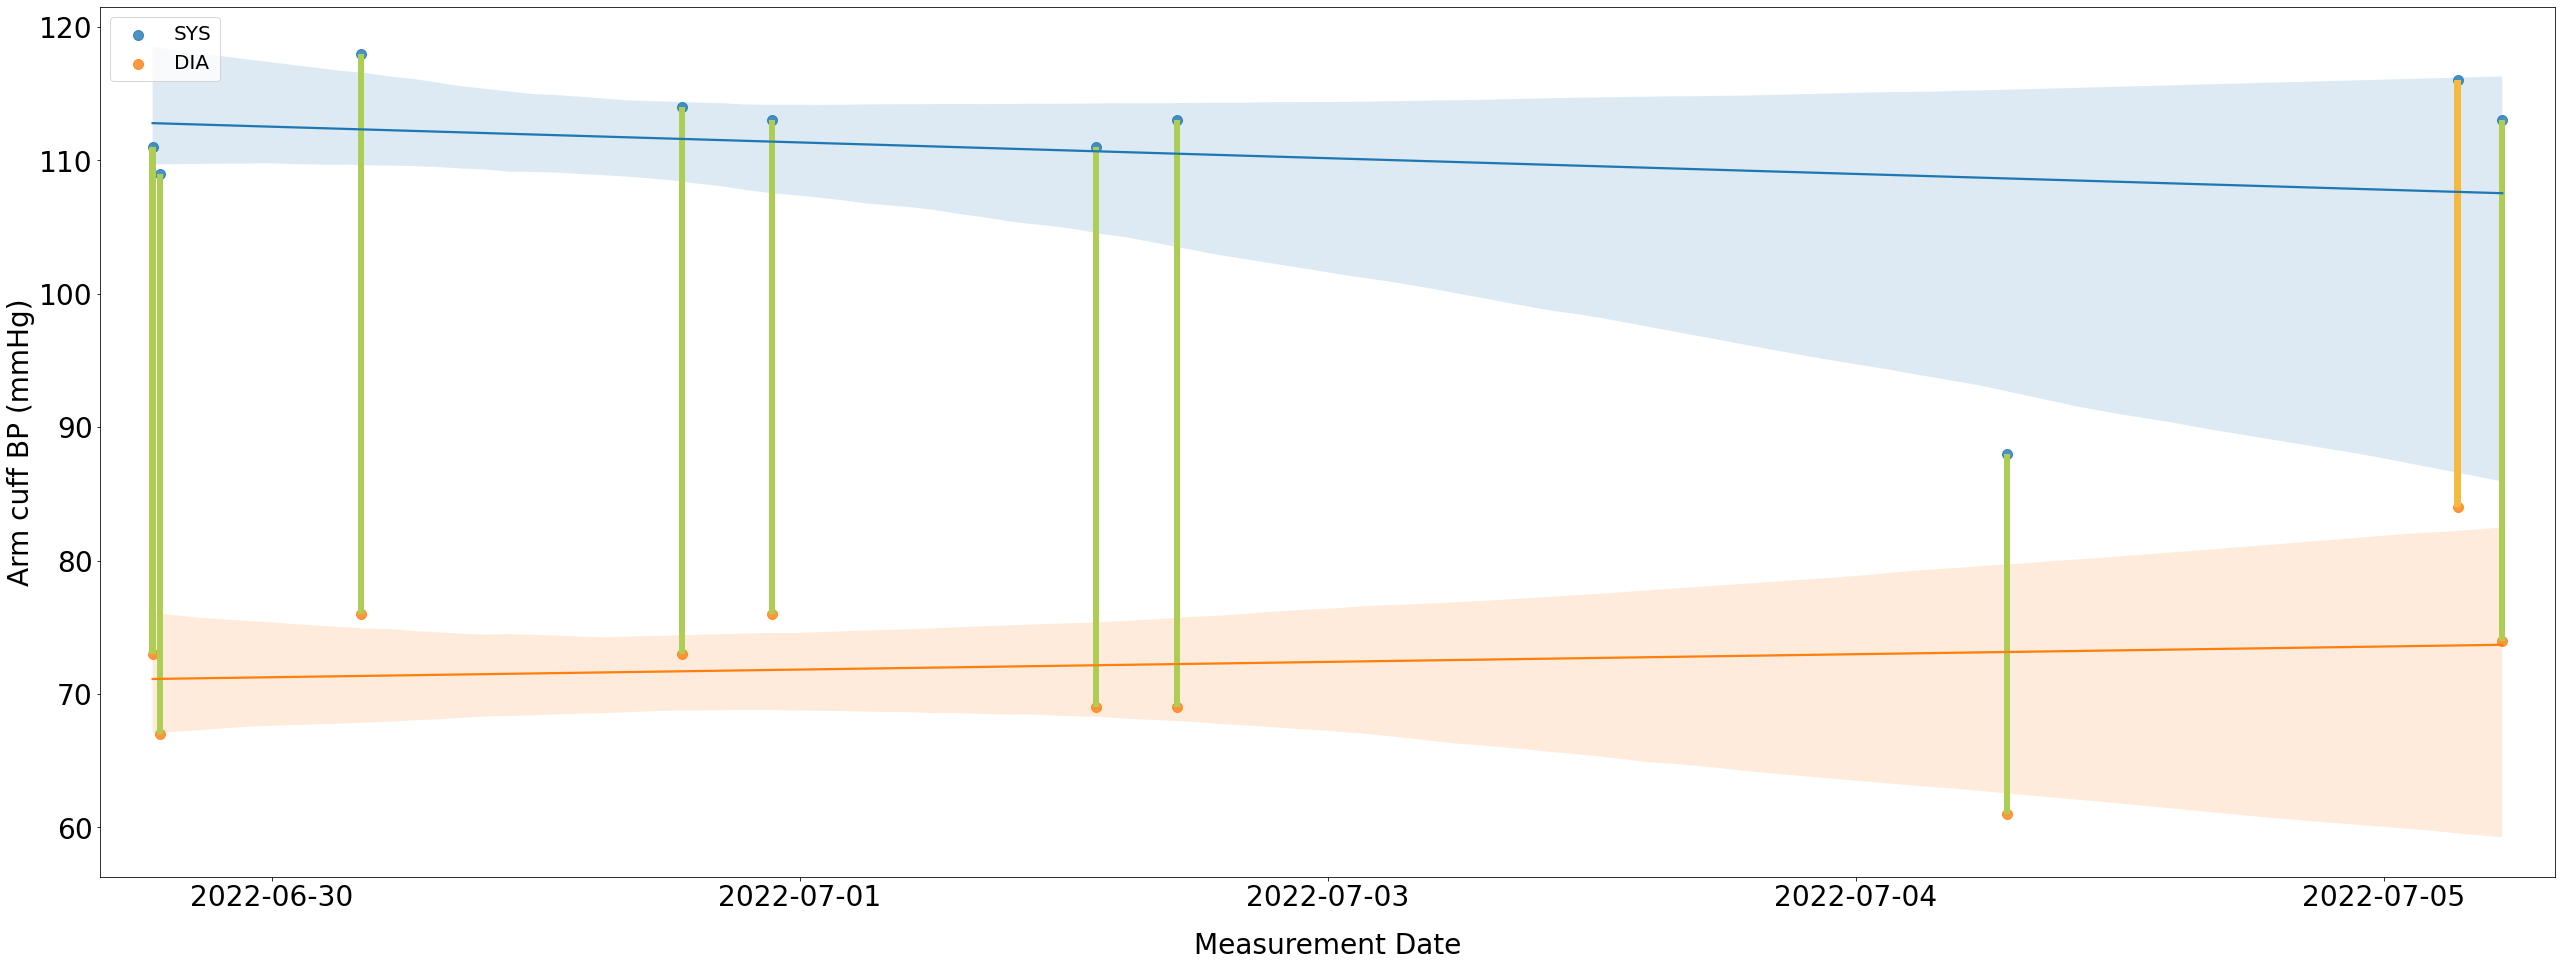

In [41]:
regplot_of_df(df_lastweek, 1200)

# Now describe last 30 days measurements and plot them (if different from last week)

In [56]:
if not df_lastweek.equals(df_lastmonth):
    display(
        df_lastmonth.describe()
    )

,SYS,DIA,Pulse,unix,elapsed_seconds
count,21.000000,21.000000,21.000000,2.100000e+01,2.100000e+01
mean,104.714286,68.238095,66.714286,1.656528e+09,3.614228e+07
std,10.464907,6.949135,4.256088,2.767356e+05,2.767356e+05
min,83.000000,56.000000,54.000000,1.656005e+09,3.561996e+07
25%,98.000000,62.000000,65.000000,1.656328e+09,3.594228e+07
50%,108.000000,69.000000,67.000000,1.656491e+09,3.610512e+07
75%,113.000000,73.000000,69.000000,1.656695e+09,3.630930e+07
max,118.000000,84.000000,73.000000,1.657022e+09,3.663702e+07


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_70537/2181959774.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


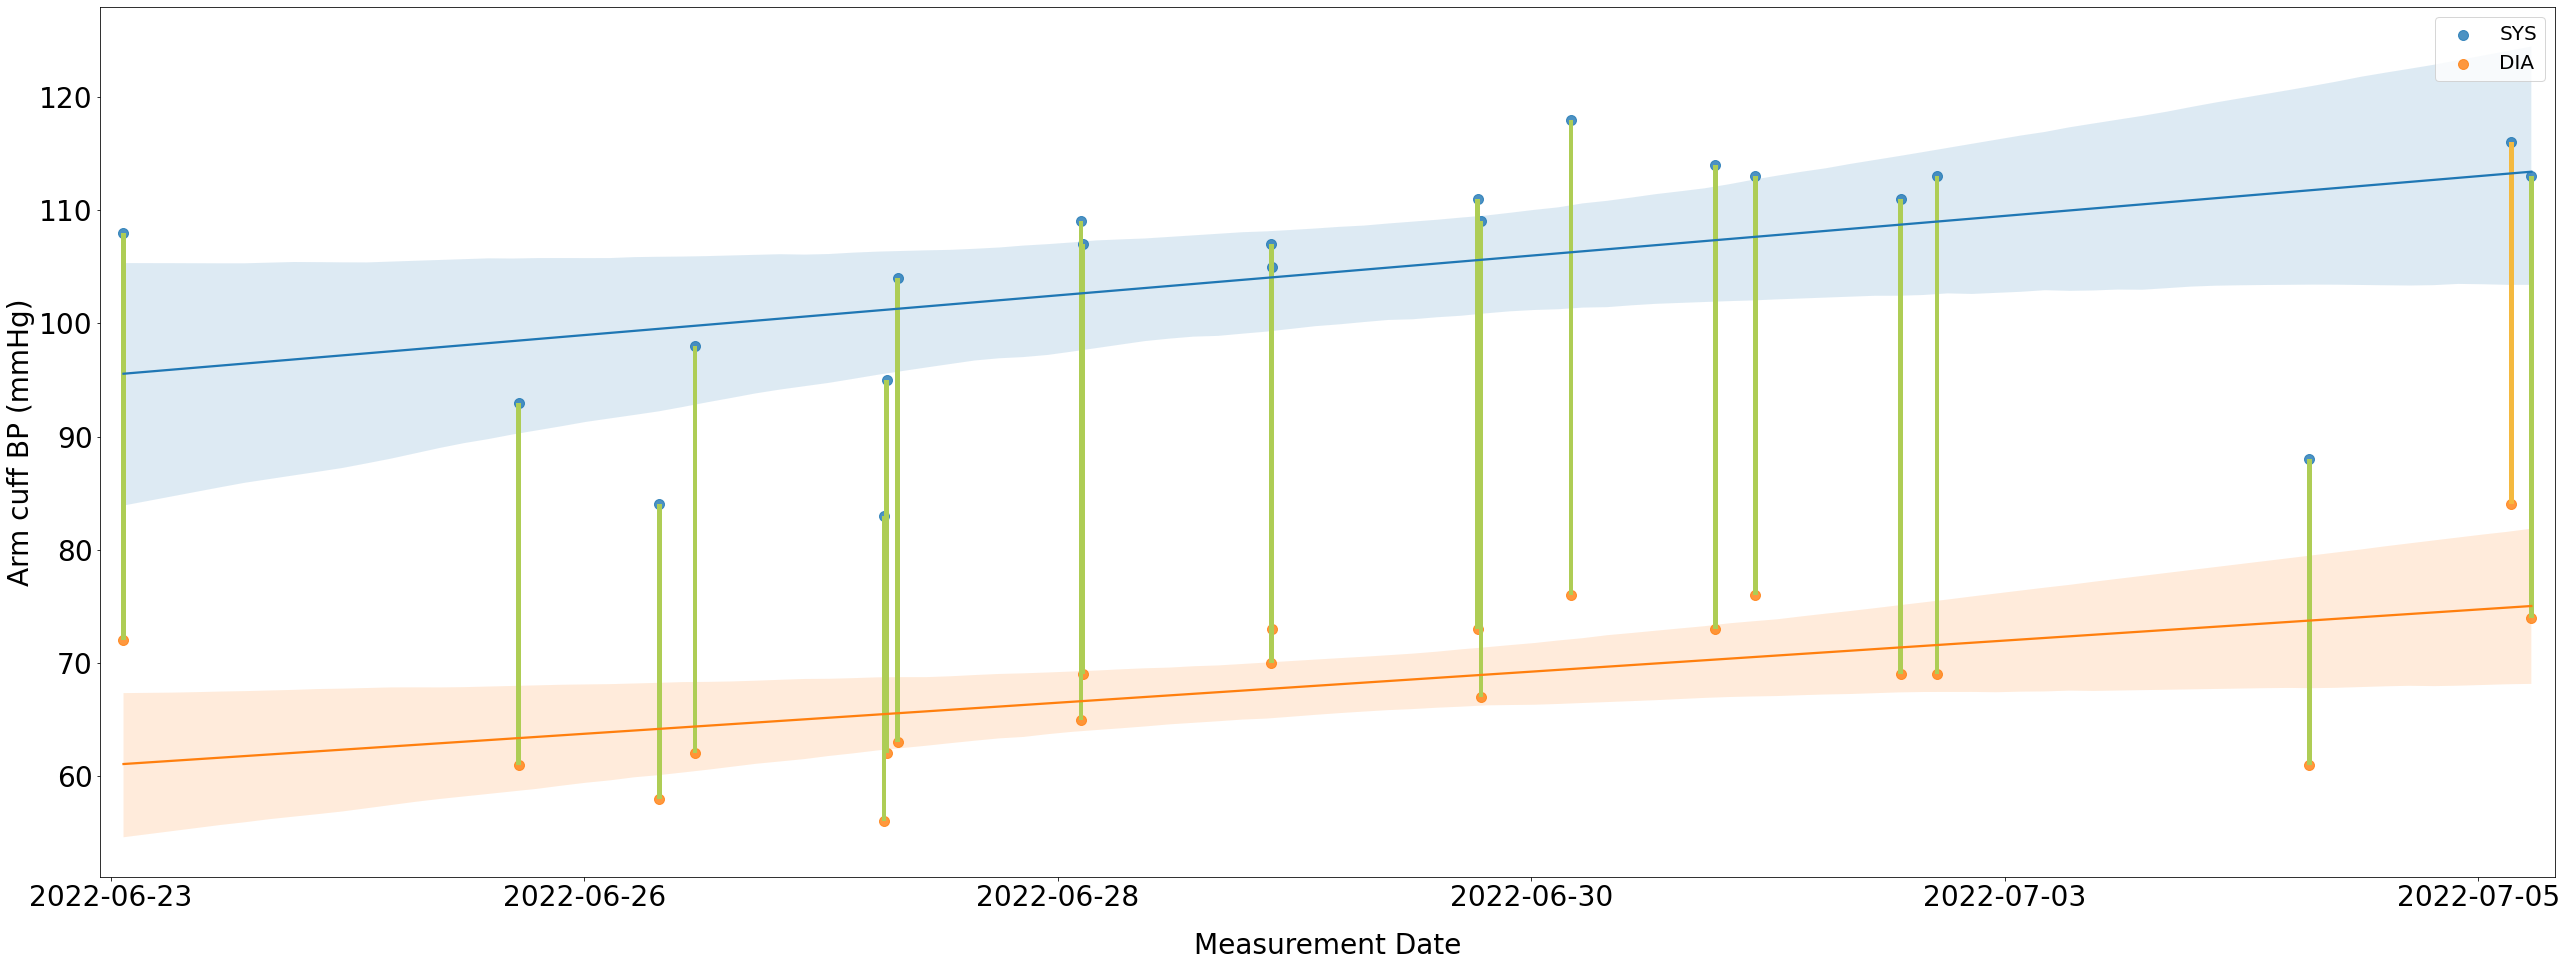

In [57]:
if not df_lastweek.equals(df_lastmonth):
    regplot_of_df(df_lastmonth, 2000)